### Task 3.1 Dataset Analysis and Preprocessing

In [2]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#### 3.1.1 Dataset Analysis

In [3]:
# Create a DataFrame
df = pd.read_csv('HousingData.csv')

# Describe the dataset
description = {
  'mean': df.mean(),
  'std': df.std(),
  'min': df.min(),
  'max': df.max()
}

description = pd.DataFrame(description)
description

,mean,std,min,max
CRIM,3.611874,8.720192,0.00632,88.9762
ZN,11.211934,23.388876,0.00000,100.0000
INDUS,11.083992,6.835896,0.46000,27.7400
CHAS,0.069959,0.255340,0.00000,1.0000
NOX,0.554695,0.115878,0.38500,0.8710
RM,6.284634,0.702617,3.56100,8.7800
AGE,68.518519,27.999513,2.90000,100.0000
DIS,3.795043,2.105710,1.12960,12.1265
RAD,9.549407,8.707259,1.00000,24.0000
TAX,408.237154,168.537116,187.00000,711.0000


#### 3.1.2 Plot showing distribution of various labels

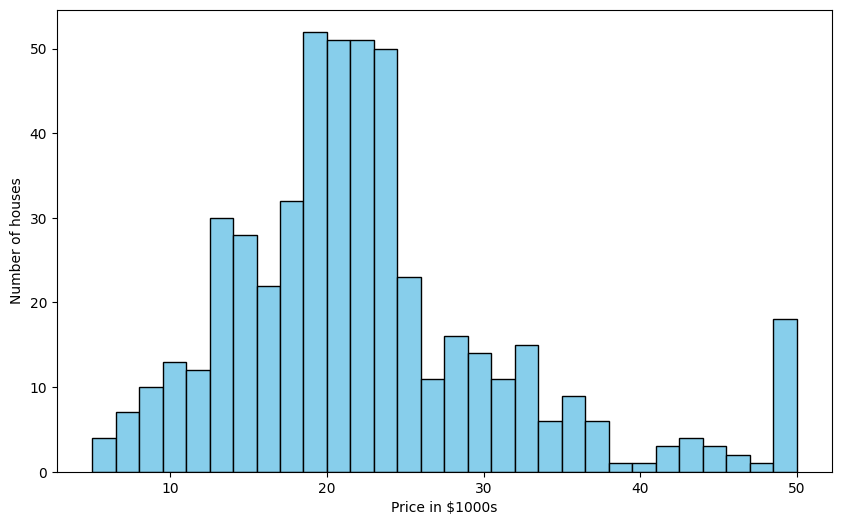

In [3]:
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
plt.hist(df['MEDV'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Price in $1000s')
plt.ylabel('Number of houses')
plt.show()


#### 3.1.3 Dataset Preprocessing

In [4]:
X = df.drop(columns=['MEDV'])  # Features
y = df['MEDV']  # Labels

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### 3.1.4 Splitting the dataset into train, validation and test sets

In [5]:
# Split the data into training, validation, and test sets
# 70% for training, 15% for validation, and 15% for testing

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (354, 13)
y_train shape: (354, 1)


### Task 3.2 MLP Regression implementation

In [11]:
class MlpRegressor:
  def __init__(
    self,
    inputLayerSize=13, 
    hiddenLayers=[4, 3], 
    outputLayerSize=1, 
    activation='relu', 
    learningRate=0.01,
    optimizer='mini-batch',
    batchSize=64, 
    iterations=10000
  ):
    self.inputLayerSize = inputLayerSize
    self.hiddenLayers = hiddenLayers
    self.outputLayerSize = outputLayerSize
    self.activation = activation
    self.learningRate = learningRate
    self.optimizer = optimizer
    self.batchSize = batchSize
    self.iterations = iterations
    
    self.weights, self.biases = self.initializeWeights()

  def initializeWeights(self):
    layerSizes = [self.inputLayerSize] + self.hiddenLayers + [self.outputLayerSize]
    weights = [np.random.randn(layerSizes[i - 1], layerSizes[i]) * np.sqrt(2.0 / (layerSizes[i - 1] + layerSizes[i])) for i in range(1, len(layerSizes))]
    biases = [np.zeros((1, layerSizes[i])) for i in range(1, len(layerSizes))]
    return weights, biases

  def activate(self, z):
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-z))
    elif self.activation == 'tanh':
      return np.tanh(z)
    elif self.activation == 'relu':
      return np.maximum(0, z)

  def activateDerivative(self, z):
    if self.activation == 'sigmoid':
      return self.activate(z) * (1 - self.activate(z))
    elif self.activation == 'tanh':
      return 1 - np.tanh(z) ** 2
    elif self.activation == 'relu':
      return np.where(z <= 0, 0, 1)
    
  def costFunction(self, X, y):
    yHat = self.forward(X)[0][-1]
    J = 0.5 * sum((y - yHat) ** 2)
    return J[0]

  def forward(self, X):
    activations = [X]
    zValues = []
    layerInput = X
    for i in range(len(self.weights)):
      z = np.dot(layerInput, self.weights[i]) + self.biases[i]
      layerOutput = self.activate(z)
      activations.append(layerOutput)
      zValues.append(z)
      layerInput = layerOutput
    return activations, zValues

  def backward(self, X, y, activations, zValues):
    m = X.shape[0]
    gradientsW = [np.zeros_like(weight) for weight in self.weights]
    gradientsB = [np.zeros_like(bias) for bias in self.biases]

    delta = (activations[-1] - y) * self.activateDerivative(zValues[-1])
    gradientsW[-1] = np.dot(activations[-2].T, delta) / m
    gradientsB[-1] = np.sum(delta, axis=0) / m

    for i in range(len(self.weights) - 2, -1, -1):
      delta = np.dot(delta, self.weights[i + 1].T) * self.activateDerivative(zValues[i])
      gradientsW[i] = np.dot(activations[i].T, delta) / m
      gradientsB[i] = np.sum(delta, axis=0) / m

    return gradientsW, gradientsB

  def computeGradients(self, X, y):
    activations, zValues = self.forward(X)
    gradientsW = self.backward(X, y, activations, zValues)
    return gradientsW
  
  def getMiniBatches(self, X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []

    # Shuffle the data before creating mini-batches
    indices = np.random.permutation(num_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = (i + 1) * batch_size
      mini_batch_X = X_shuffled[start_idx:end_idx]
      mini_batch_y = y_shuffled[start_idx:end_idx]
      mini_batches.append((mini_batch_X, mini_batch_y))

    # If there are remaining samples, create one more mini-batch
    if num_samples % batch_size != 0:
      mini_batch_X = X_shuffled[num_batches * batch_size:]
      mini_batch_y = y_shuffled[num_batches * batch_size:]
      mini_batches.append((mini_batch_X, mini_batch_y))

    return mini_batches
  
  def updateWeights(self, gradientsW, gradientsB):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learningRate * gradientsW[i]
      self.biases[i] -= self.learningRate * gradientsB[i]
      
  def getMetrics(self, yHat, y):
    # compute mse, rmse, and rsquared
    mse = np.mean((y - yHat) ** 2)
    rmse = np.sqrt(mse)
    ssr = np.sum((yHat - y) ** 2)
    sst = np.sum((y - y.mean()) ** 2)
    rsquared = 1 - (ssr / sst)
    return mse, rmse, rsquared


In [8]:
class Trainer(object):
  def __init__(self, N):
    # Make Local reference to network:
    self.N = N
    
  def sgd(self, X, y):
    k = 0
    for i in range(len(X)):
      x_sgd = X[i].reshape(1, -1)
      y_sgd = y[i].reshape(1, -1)
      gradw, gradb = self.N.computeGradients(x_sgd, y_sgd)
      self.N.updateWeights(gradw, gradb)
      k += 1
    return k

  def miniBatch(self, X, y, batch_size):
    k = 0
    mini_batches = self.N.getMiniBatches(X, y, batch_size=batch_size)
    for x_mini, y_mini in mini_batches:
      gradw, gradb = self.N.computeGradients(x_mini, y_mini)
      self.N.updateWeights(gradw, gradb)
      k += 1
    return k
  
  def batch(self, X, y):
    gradw, gradb = self.N.computeGradients(X, y)
    self.N.updateWeights(gradw, gradb)
    return 1
  
  def optimiser(self, X, y):
    if self.N.optimizer == 'sgd':
      return self.sgd(X, y)
    elif self.N.optimizer == 'mini-batch':
      return self.miniBatch(X, y, self.N.batchSize)
    elif self.N.optimizer == 'batch':
      return self.batch(X, y)
    
  def getMetrics(self, X, y):
    yHat = self.predict(X)
    mse, rmse, rsquared = self.N.getMetrics(yHat, y)
    print('--'*50)
    print('Metrics for the data set:')
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', rsquared)
    print('--'*50)
    return mse, rmse, rsquared
  
  def predict(self, X):
    return self.N.forward(X)[0][-1]

  def train(self, X, y):
    self.X = X
    self.y = y

    self.J = []

    loss = self.N.costFunction(X, y)
    k = 0
    maxiter = self.N.iterations

    while (loss > 1e-5) and (k < maxiter):
      k += self.optimiser(X, y)
      loss = self.N.costFunction(X, y)
      self.J.append(loss)
      if k % 1000 == 0:
        print("Iteration %d: loss = %f" % (k, loss))

    print("Training Complete!!!")
    print("         Iterations: %d" % k)
    print("         Final loss function: %f" % loss)

In [14]:
mlp = MlpRegressor(
  inputLayerSize=X_train.shape[1],
  hiddenLayers=[110,10],
  outputLayerSize=1,
  activation='relu',
  learningRate=0.001,
  optimizer='batch',
  iterations=1000,
)

T = Trainer(mlp)
T.train(X_train, y_train)

Iteration 1000: loss = 3653.244526
Training Complete!!!
         Iterations: 1000
         Final loss function: 3653.244526


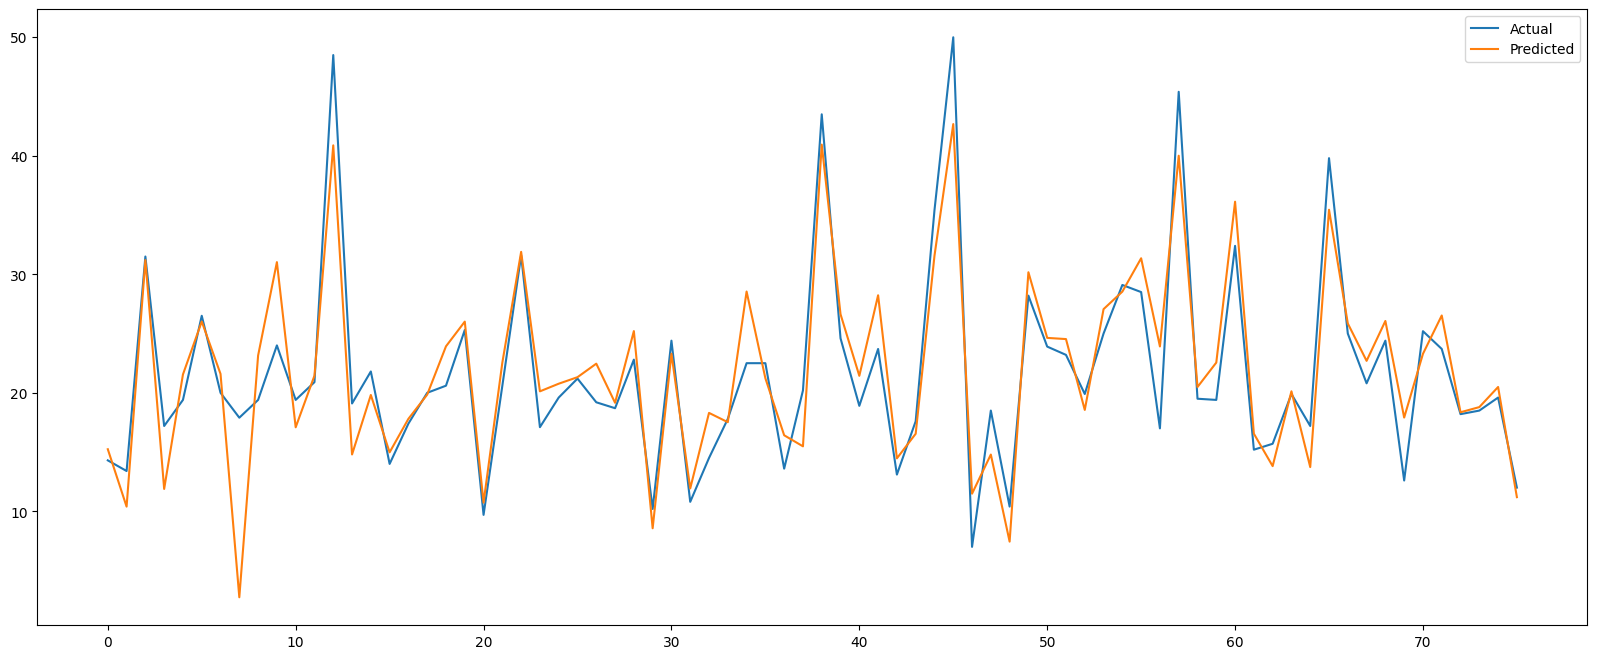

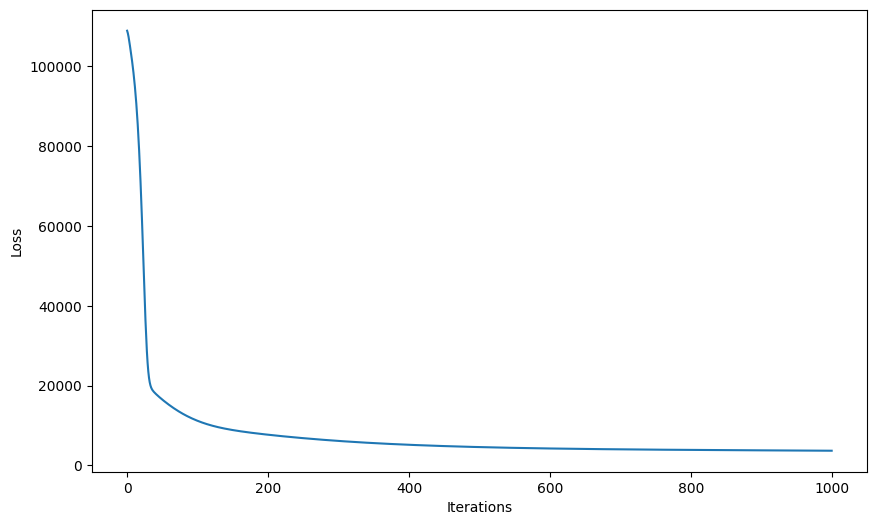

In [15]:
y_pred = T.predict(X_val)
mlp.getMetrics(y_pred, y_val)

plt.figure(figsize=(20, 8))
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Task 3.3 Hyperparameter Tuning

In [10]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = '/Users/chnaveen/Documents/sem5/smai/assignments/assignment-3/problem3/problem3.ipynb'

sweep_config = {
  "method": "grid",
  "metric": {
    "name": "rsq_val",
    "goal": "maximize"
  },
  "parameters": {
    "learningRate": {"values": [0.0005, 0.001]},
    "hiddenLayers": {"values": [[6, 2], [8, 3]]},
    "activation": {"values": ["relu", "sigmoid", 'tanh']},
    "optimizer": {"values": ["sgd", "mini-batch", "batch"]},
    "batchSize": {"values": [32, 64]},
    "iterations": {"values": [100000, 200000]}
  }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Multilayer-Perceptron-Regressor")

# Define sweep function
def sweep_function():
  with wandb.init(config=sweep_config):
    optimizer = wandb.config.optimizer
    batchSize = wandb.config.batchSize
    activation = wandb.config.activation
    iterations = wandb.config.iterations
    hiddenLayers = wandb.config.hiddenLayers
    learningRate = wandb.config.learningRate
    
    mlp_tune = MlpRegressor(
      inputLayerSize=X_train.shape[1],
      hiddenLayers=hiddenLayers,
      outputLayerSize=y_train.shape[1],
      activation=activation,
      learningRate=learningRate,
      optimizer=optimizer,
      batchSize=batchSize,
      iterations=iterations
    )
    
    T_tune = Trainer(mlp_tune)
    T_tune.train(X_train, y_train)
    
    print('Metrics on Train Set:')
    print('--'*50)
    T_tune.getMetrics(X_train, y_train)
    print('--'*50)
    
    print('Metrics on Validation Set:')
    print('--'*50)
    mse_val, rmse_val, rsq_val = T_tune.getMetrics(X_val, y_val)
    print('--'*50)
    
    # Log hyperparameters and validation loss
    wandb.log({
      'learningRate': learningRate,
      'iterations': iterations,
      'optimizer': optimizer,
      'batchSize': batchSize,
      'activation': activation,
      'hiddenLayers': hiddenLayers,
      'mse_val': mse_val,
      'rmse_val': rmse_val,
      'rsq_val': rsq_val,
      'val_loss': T_tune.J[-1],
    })
    
wandb.agent(sweep_id, function=sweep_function)


#### wandb logging done

In [14]:
api = wandb.Api()

best_run = api.sweep("chnaveenin/Multilayer-Perceptron-Regressor/sweeps/"+'pjnyq72i').best_run()
print('Results for best run:')
print(
  'epochs:', best_run.config['iterations'], '\n'
  'learning_rate:', best_run.config['learningRate'], '\n'
  'hidden_layers:', best_run.config['hiddenLayers'], '\n'
  'activation:', best_run.config['activation'], '\n'
  'optimizer:', best_run.config['optimizer'], '\n'
  'batch_size:', best_run.config['batchSize'], '\n'
  'rsq_val:', best_run.summary['rsq_val'], '\n'
)

wandb: Sorting runs by -summary_metrics.rsq_val


Results for best run:
epochs: 200000 
learning_rate: 0.0005 
hidden_layers: [6, 2] 
activation: relu 
optimizer: mini-batch 
batch_size: 64 
rsq_val: 0.9215396895938716 



### Task 3.4 Evaluating Model

Iteration 3000: loss = 3430.331666
Iteration 6000: loss = 2750.467385
Iteration 9000: loss = 2424.208314
Iteration 12000: loss = 2228.581426
Iteration 15000: loss = 2024.703154
Iteration 18000: loss = 1866.888667
Iteration 21000: loss = 1748.229652
Iteration 24000: loss = 1686.082434
Iteration 27000: loss = 1640.021831
Iteration 30000: loss = 1576.015431
Iteration 33000: loss = 1550.412543
Iteration 36000: loss = 1539.067217
Iteration 39000: loss = 1521.184535
Iteration 42000: loss = 1491.546655
Iteration 45000: loss = 1468.617506
Iteration 48000: loss = 1452.185322
Iteration 51000: loss = 1445.532893
Iteration 54000: loss = 1445.252919
Iteration 57000: loss = 1429.598400
Iteration 60000: loss = 1425.322951
Iteration 63000: loss = 1418.673258
Iteration 66000: loss = 1409.660026
Iteration 69000: loss = 1390.935708
Iteration 72000: loss = 1379.220612
Iteration 75000: loss = 1366.171398
Iteration 78000: loss = 1404.377865
Iteration 81000: loss = 1343.193355
Iteration 84000: loss = 1323.31

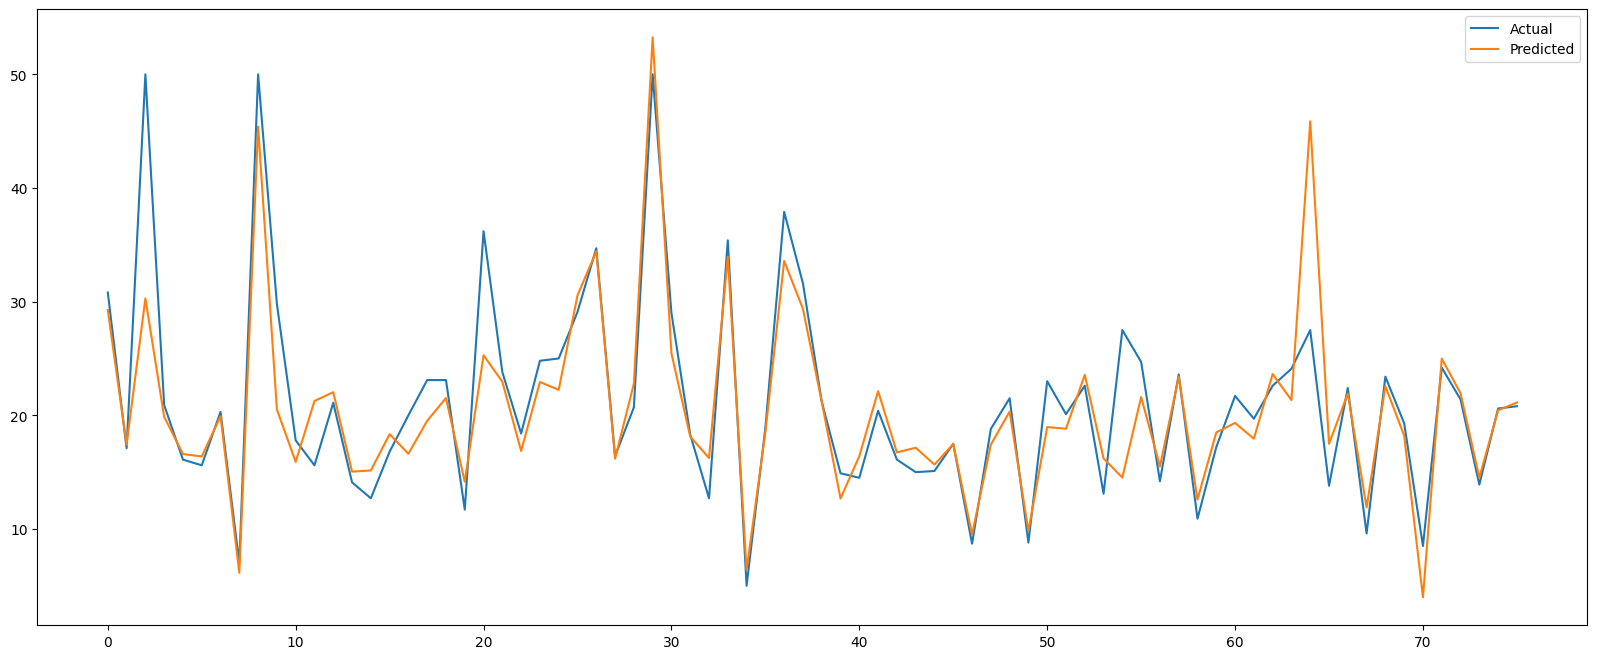

In [24]:
mlp_best = MlpRegressor(
  inputLayerSize=X_train.shape[1],
  hiddenLayers=best_run.config['hiddenLayers'],
  outputLayerSize=y_train.shape[1],
  activation=best_run.config['activation'],
  learningRate=best_run.config['learningRate'],
  optimizer=best_run.config['optimizer'],
  batchSize=best_run.config['batchSize'],
  iterations=best_run.config['iterations']
)

T_best = Trainer(mlp_best)
T_best.train(X_train, y_train)

print('--'*50)
print('Metrics for the test set:')
T_best.getMetrics(X_test, y_test)
print('--'*50)

y_pred_test = T_best.predict(X_test)

plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.legend()
plt.show()